# End-to-End Camera Calibration

Simulated data to support the idea of end-to-end camera transformation.

For details on the idea, see [the doc](https://docs.google.com/document/d/1-ikSOxtrC4HLzd8xBdokjfMbbz0616eOBsco-bDk3os/edit)

### Imports

In [420]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp

np.set_printoptions(precision=2, floatmode='fixed', suppress=True, threshold=10)

### Real world points

In [435]:
# open cv world coords: x right, y down, z forward.
# distance 5 m side to side
x_space_cv = np.linspace(-5, 5, 21)
# y is down, and zero is at the floor
y_space_cv = np.linspace(-0.5, -1.5, 5)
# y_space_cv = np.linspace(-1, -2, 10)
# distance from 0.5 to 5 meters
z_space_cv = np.linspace(0.5, 5, 10)
X_cv, Y_cv, Z_cv = np.meshgrid(x_space_cv, y_space_cv, z_space_cv)
X_cv = X_cv.reshape(1, -1).T
Y_cv = Y_cv.reshape(1, -1).T
Z_cv = Z_cv.reshape(1, -1).T

### Camera intrinsics and pose

In [436]:
# intrinsic matrix
K = np.array([[300.0, 0.0, 250.0], [0.0, 300.0, 250.0], [0.0, 0.0, 1.0]])

# distortion coefficients (k1, k2, p1, p2, k3)
# A LOT of distortion, in order to see it work.
distCoeffs = np.array([1.5, -0.95, -0.005, 0.0025, 1.16])
# distCoeffs = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# world in camera coordinates: camera up means world down.
rvec = np.array([-0.4, 0.0, 0.0])
# camera is 0.5m up (negative) from the floor, which means world is 0.5m down (positive)
tvec = np.array([0.0, 0.2, 0.0])

### Project points to pixels, (u, v)

For each tag height, the points look like a "ceiling" above the camera

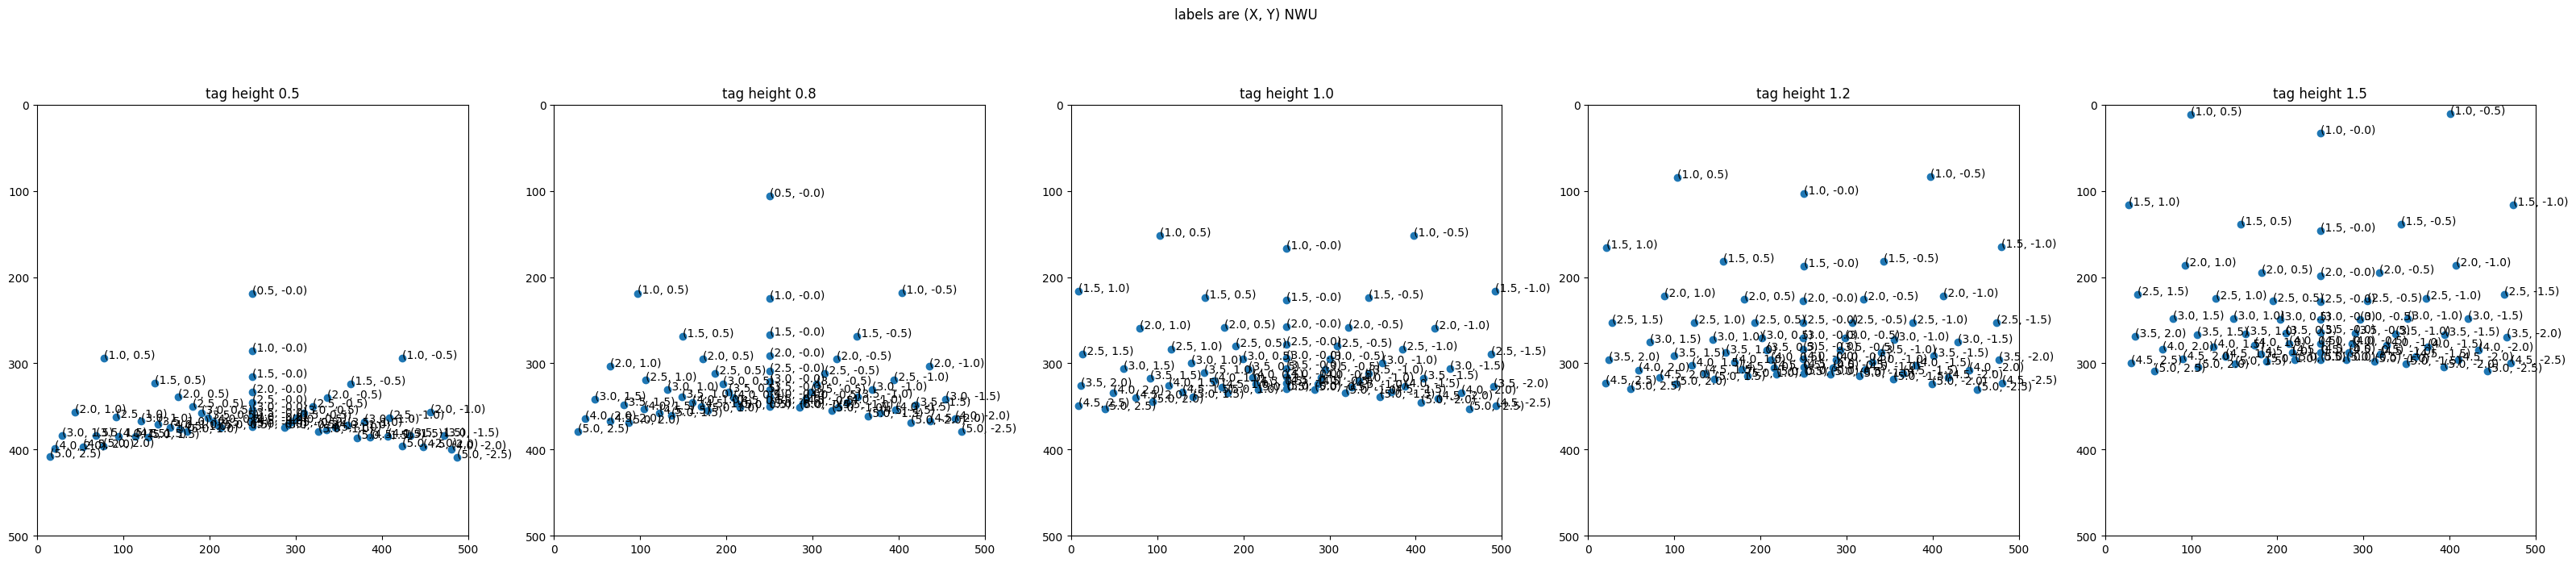

In [447]:
XYZ_cv = np.hstack((X_cv, Y_cv, Z_cv))
U_dist, _ = cv2.projectPoints(XYZ_cv, rvec, tvec, K, distCoeffs)
# (u, v) are pixels
uv = U_dist[:, 0]

X_nwu = Z_cv  # ahead
Y_nwu = -X_cv  # left
Z_nwu = -Y_cv  # up

# this is the training data
uvZXY_nwu = np.hstack((uv, Z_nwu, X_nwu, Y_nwu))
uvZXY_nwu = uvZXY_nwu[
    (uvZXY_nwu[:, 0] >= 0)
    & (uvZXY_nwu[:, 1] >= 0)
    & (uvZXY_nwu[:, 0] <= 500)
    & (uvZXY_nwu[:, 1] <= 500)
]

fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle("labels are (X, Y) NWU")

for i, tag_height in enumerate(y_space_cv):
    for_height = uvZXY_nwu[np.isclose(uvZXY_nwu[:, 2], -tag_height)]
    uuu = for_height.T[0]
    vvv = for_height.T[1]
    ax[i].scatter(uuu, vvv)
    ax[i].set_title(f"tag height {-tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()  # camera y is positive-down
    for ii, row in enumerate(for_height):
        ax[i].annotate(f"({row[3]}, {row[4]})", (row[0], row[1]))

plt.show()

### Predict XZ (robot-relative Translation2d)  from simulated uvY

This uses (X, Y, Z) robot-relative NWU coordinates and (u, v) pixels

There are multiple interpolation options.

The simplest one, **LinearNDInterpolator,** works pretty well, and is pretty fast.

The fanciest one, **RBFInterpolator,** does not work well at all with the default settings: kernels like 'cubic' appear be overfitting somehow.  Using the 'linear' kernel with heavy smoothing, it's not too bad, but still not better than the linear interpolator.

The main interesting thing about the RBF interpolator is that it extrapolates outside the range of observations, but it doesn't seem to do a very good job.  X (range) extrapolations for the top half of the frame are *further away* than estimates for the middle, for example.

So we should use the linear interpolator, and make sure we give it enough examples around the edges of the frame.


In [452]:
uvZ_nwu_to_XY_nwu_rbf = interp.RBFInterpolator(uvZXY_nwu[:,(0,1,2)], uvZXY_nwu[:,(3,4)], smoothing=0, degree=2, kernel='linear')
uvZ_nwu_to_XY_nwu_linear = interp.LinearNDInterpolator(uvZXY_nwu[:,(0,1,2)], uvZXY_nwu[:,(3,4)])


### What do these functions look like?

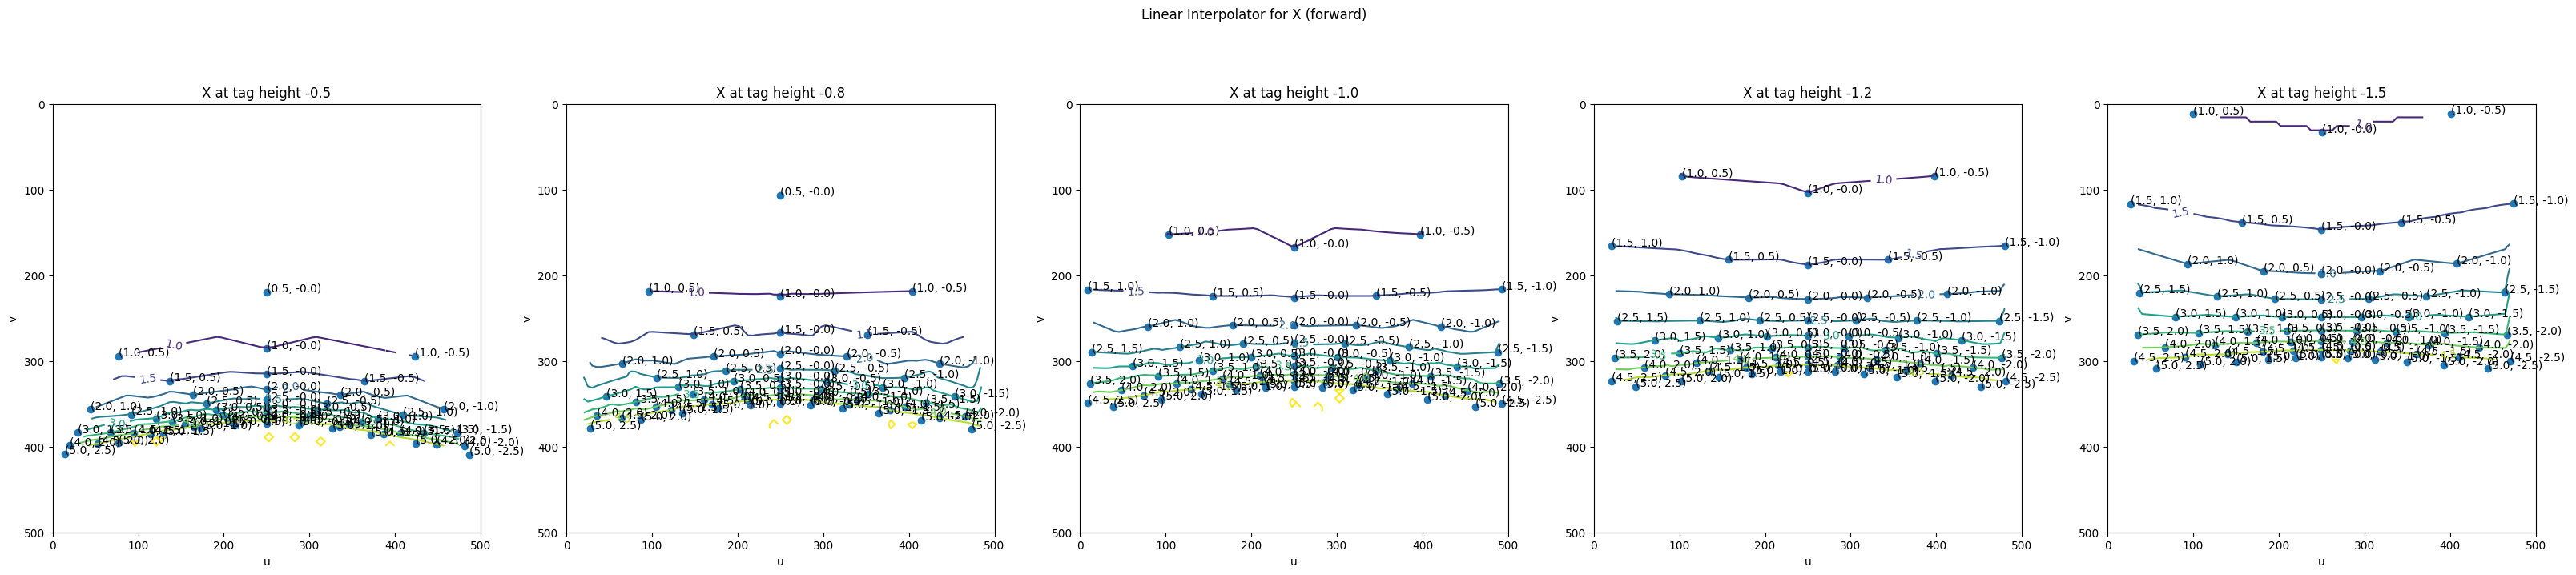

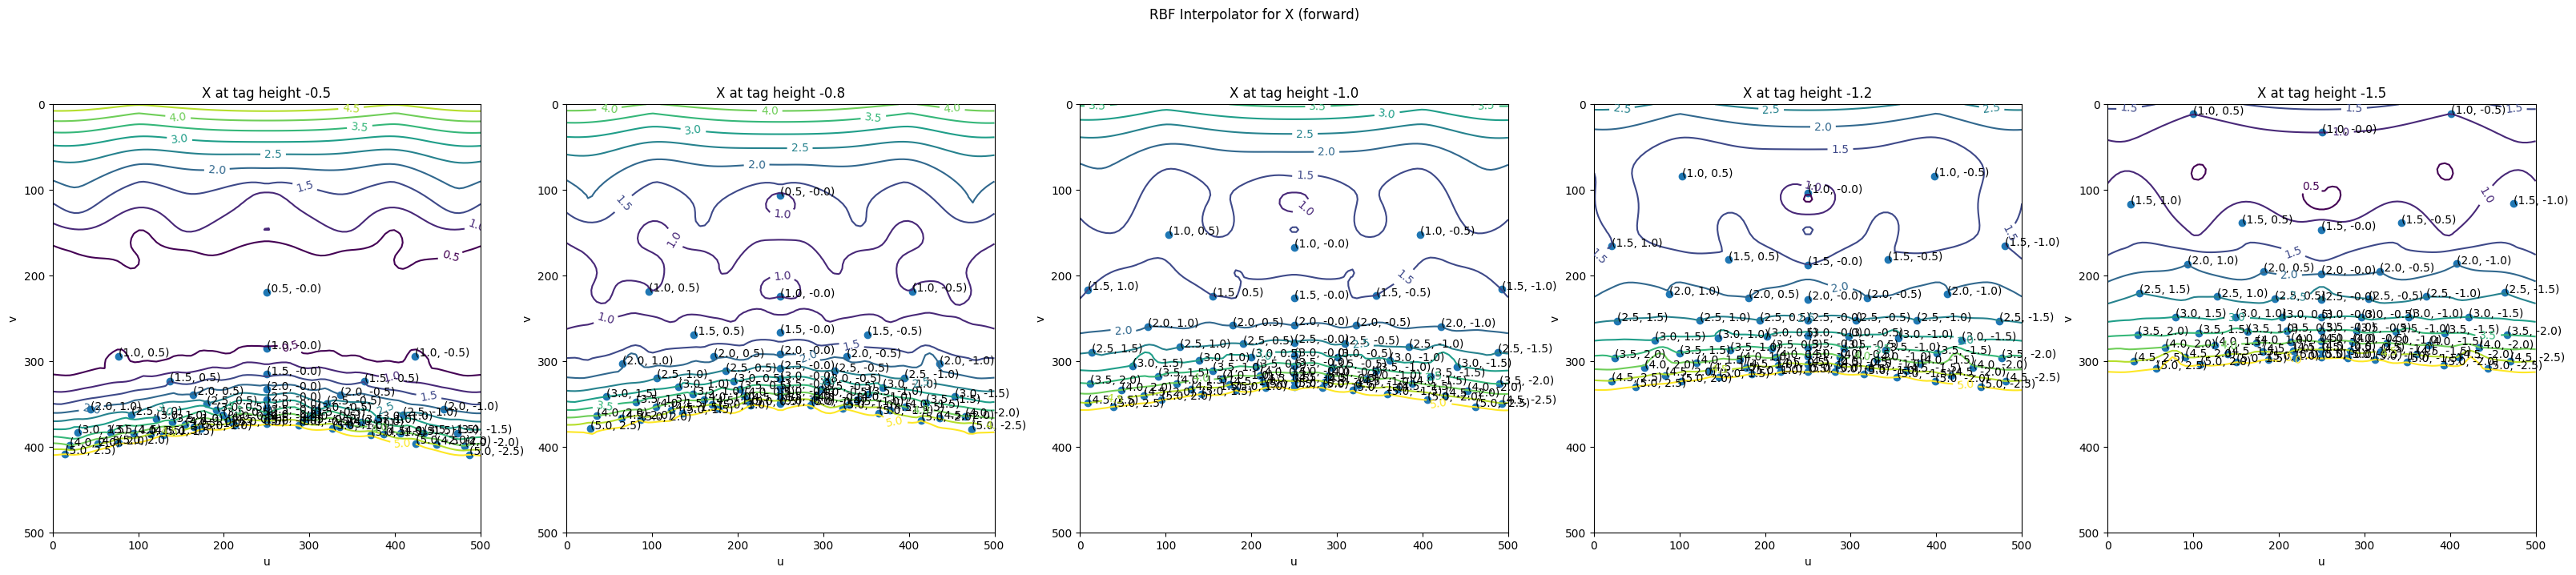

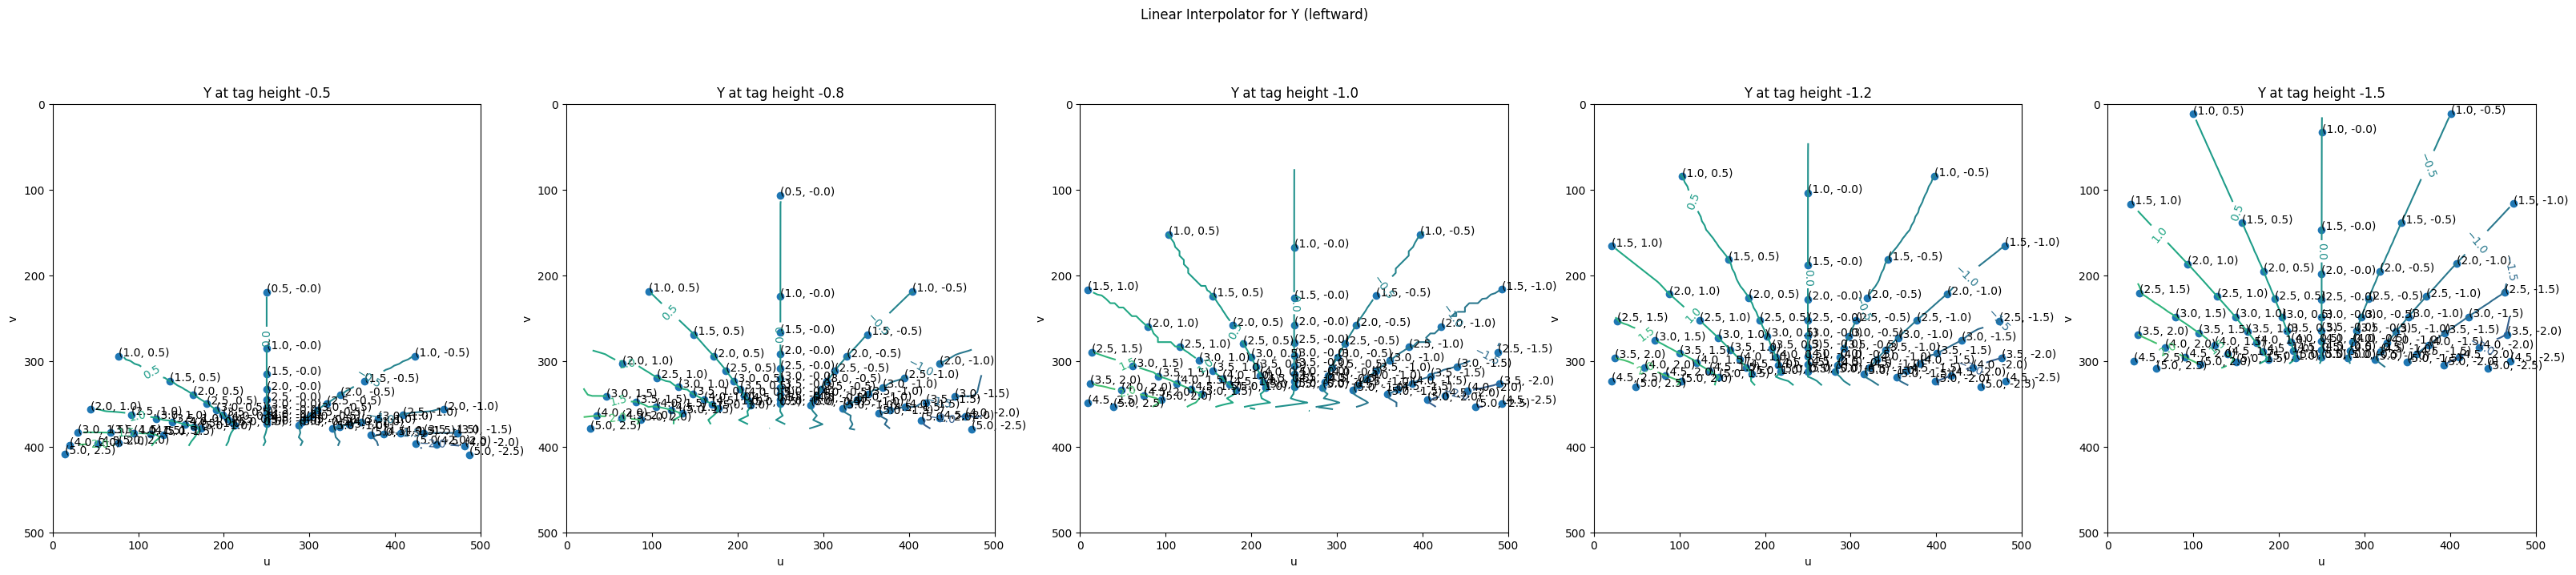

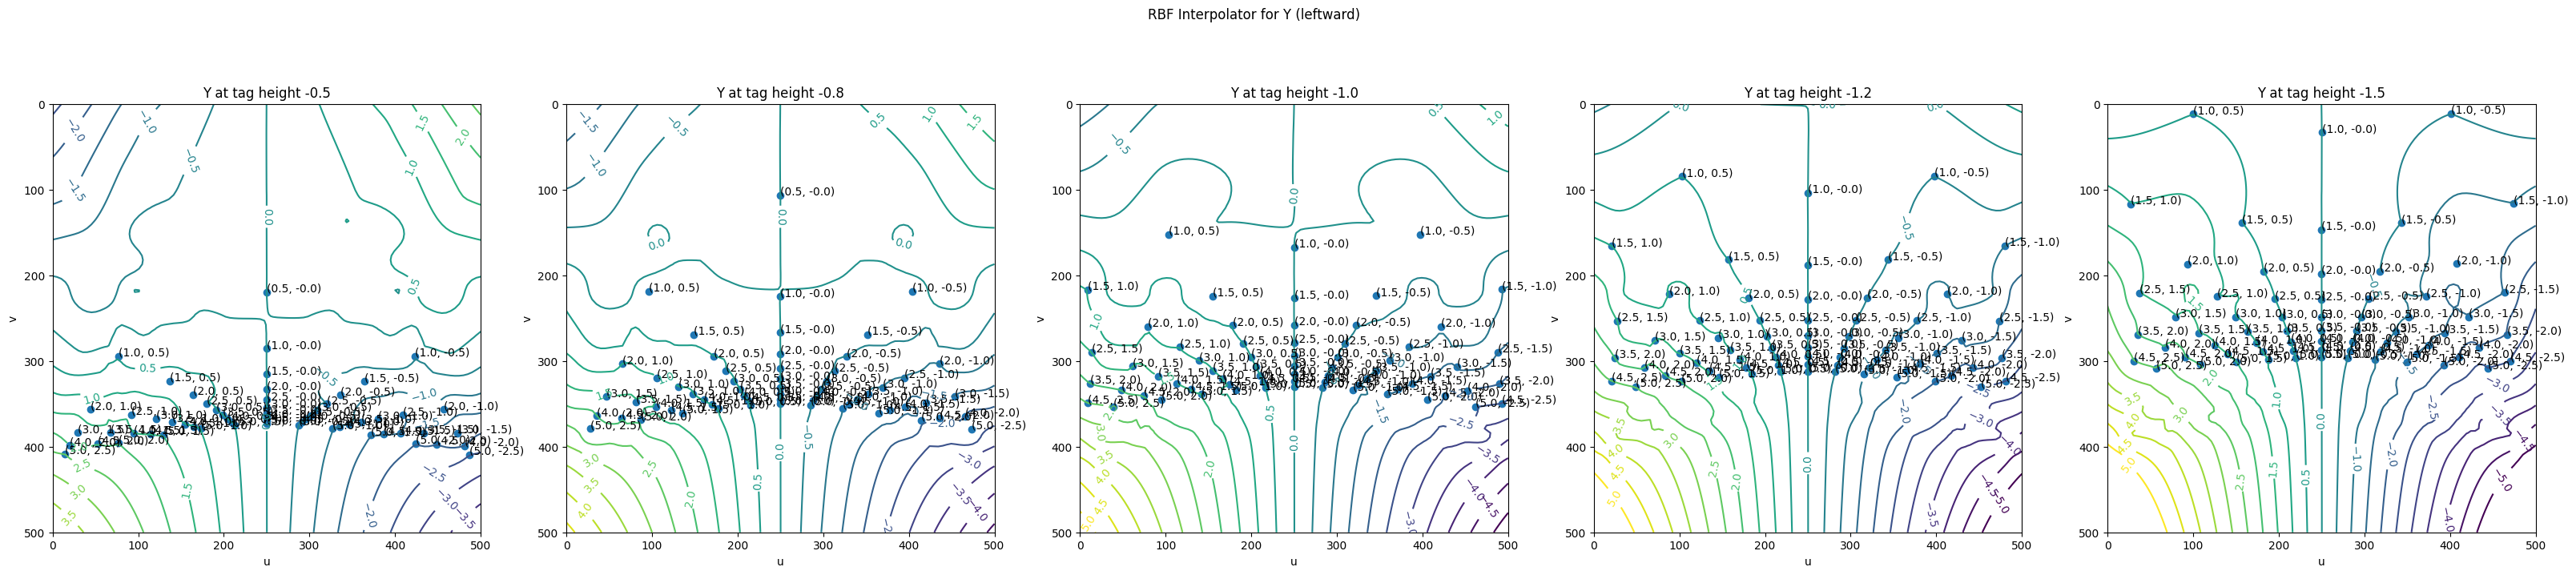

In [454]:
u_i = np.linspace(0,500,100)
v_i = np.linspace(0,500,100)

u_col = u_i.reshape(1,-1).T
v_col = v_i.reshape(1,-1).T

x_contour_space = np.linspace(0.5, 5, 10)
y_contour_space = np.linspace(-5, 5, 21)


# for X
fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle('Linear Interpolator for X (forward)')
for i, tag_height in enumerate(y_space_cv):
    uu, vv, ZZ = np.meshgrid(u_col, v_col, -tag_height)
    uu = uu.reshape(1, -1).T
    vv = vv.reshape(1, -1).T
    ZZ = ZZ.reshape(1, -1).T

    uvZ_nwu_for_height = np.hstack((uu,vv,ZZ))
    predictedXY_nwu_for_height = uvZ_nwu_to_XY_nwu_linear(uvZ_nwu_for_height)


    predictedX_nwu_for_height = predictedXY_nwu_for_height[:, 0]
    u_for_height = uvZ_nwu_for_height[:, 0]
    # print(u_for_height.shape)
    v_for_height = uvZ_nwu_for_height[:, 1]
    X_nwu_i = interp.griddata(
        (u_for_height, v_for_height),
        predictedX_nwu_for_height,
        (u_i[None, :], v_i[:, None]),
        method="linear",
    )

    CS = ax[i].contour(u_i, v_i, X_nwu_i, x_contour_space)
    plt.clabel(CS, inline=1, fontsize=10)
    ax[i].set_xlabel("u")
    ax[i].set_ylabel("v")
    ax[i].set_title(f"X at tag height {tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()

    # overlay the ground truth
    for_height = uvZXY_nwu[np.isclose(uvZXY_nwu[:, 2], -tag_height)]
    uuu = for_height.T[0]
    vvv = for_height.T[1]
    ax[i].scatter(uuu, vvv)
    for ii, row in enumerate(for_height):
        ax[i].annotate(f'({row[3]}, {row[4]})', (row[0], row[1]))

plt.show()

# for X
fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle('RBF Interpolator for X (forward)')
for i, tag_height in enumerate(y_space_cv):
    uu, vv, ZZ = np.meshgrid(u_col, v_col, -tag_height)
    uu = uu.reshape(1, -1).T
    vv = vv.reshape(1, -1).T
    ZZ = ZZ.reshape(1, -1).T

    uvZ_nwu_for_height = np.hstack((uu,vv,ZZ))
    predictedXY_nwu_for_height = uvZ_nwu_to_XY_nwu_rbf(uvZ_nwu_for_height)


    predictedX_nwu_for_height = predictedXY_nwu_for_height[:, 0]
    u_for_height = uvZ_nwu_for_height[:, 0]
    # print(u_for_height.shape)
    v_for_height = uvZ_nwu_for_height[:, 1]
    X_nwu_i = interp.griddata(
        (u_for_height, v_for_height),
        predictedX_nwu_for_height,
        (u_i[None, :], v_i[:, None]),
        method="linear",
    )

    CS = ax[i].contour(u_i, v_i, X_nwu_i, x_contour_space)
    plt.clabel(CS, inline=1, fontsize=10)
    ax[i].set_xlabel("u")
    ax[i].set_ylabel("v")
    ax[i].set_title(f"X at tag height {tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()

    # overlay the ground truth
    for_height = uvZXY_nwu[np.isclose(uvZXY_nwu[:, 2], -tag_height)]
    uuu = for_height.T[0]
    vvv = for_height.T[1]
    ax[i].scatter(uuu, vvv)
    for ii, row in enumerate(for_height):
        ax[i].annotate(f'({row[3]}, {row[4]})', (row[0], row[1]))

plt.show()


# for Y
fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle('Linear Interpolator for Y (leftward)')
for i, tag_height in enumerate(y_space_cv):    
    uu, vv, ZZ = np.meshgrid(u_col, v_col, -tag_height)
    uu = uu.reshape(1, -1).T
    vv = vv.reshape(1, -1).T
    ZZ = ZZ.reshape(1, -1).T

    uvZ_nwu_for_height = np.hstack((uu,vv,ZZ))
    predictedXY_nwu_for_height = uvZ_nwu_to_XY_nwu_linear(uvZ_nwu_for_height)

    predictedY_nwu_for_height = predictedXY_nwu_for_height[:, 1]
    Y_nwu_i = interp.griddata(
        (uvZ_nwu_for_height[:, 0], uvZ_nwu_for_height[:, 1]),
        predictedY_nwu_for_height,
        (u_i[None, :], v_i[:, None]),
        method="linear",
    )

    CS = ax[i].contour(u_i, v_i, Y_nwu_i, y_contour_space)
    plt.clabel(CS, inline=1, fontsize=10)
    ax[i].set_xlabel("u")
    ax[i].set_ylabel("v")
    ax[i].set_title(f"Y at tag height {tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()

    # overlay the ground truth
    for_height = uvZXY_nwu[np.isclose(uvZXY_nwu[:, 2], -tag_height)]
    uuu = for_height.T[0]
    vvv = for_height.T[1]
    ax[i].scatter(uuu, vvv)
    for ii, row in enumerate(for_height):
        ax[i].annotate(f'({row[3]}, {row[4]})', (row[0], row[1]))
plt.show()





# for Y
fig, ax = plt.subplots(1, y_space_cv.size, figsize=(40, 8))
fig.suptitle('RBF Interpolator for Y (leftward)')
for i, tag_height in enumerate(y_space_cv):    
    uu, vv, ZZ = np.meshgrid(u_col, v_col, -tag_height)
    uu = uu.reshape(1, -1).T
    vv = vv.reshape(1, -1).T
    ZZ = ZZ.reshape(1, -1).T

    uvZ_nwu_for_height = np.hstack((uu,vv,ZZ))
    predictedXY_nwu_for_height = uvZ_nwu_to_XY_nwu_rbf(uvZ_nwu_for_height)

    predictedY_nwu_for_height = predictedXY_nwu_for_height[:, 1]
    Y_nwu_i = interp.griddata(
        (uvZ_nwu_for_height[:, 0], uvZ_nwu_for_height[:, 1]),
        predictedY_nwu_for_height,
        (u_i[None, :], v_i[:, None]),
        method="linear",
    )

    CS = ax[i].contour(u_i, v_i, Y_nwu_i, y_contour_space)
    plt.clabel(CS, inline=1, fontsize=10)
    ax[i].set_xlabel("u")
    ax[i].set_ylabel("v")
    ax[i].set_title(f"Y at tag height {tag_height:.1f}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()

    # overlay the ground truth
    for_height = uvZXY_nwu[np.isclose(uvZXY_nwu[:, 2], -tag_height)]
    uuu = for_height.T[0]
    vvv = for_height.T[1]
    ax[i].scatter(uuu, vvv)
    for ii, row in enumerate(for_height):
        ax[i].annotate(f'({row[3]}, {row[4]})', (row[0], row[1]))
plt.show()


### RBFInterpolator performance

This shows about 10 us on my laptop, which is a 3 GHz i7; a Raspberry Pi 4 runs at 1.8 GHz, so say it's half as fast, so the interpolation might take 20 us.

Compare this to the previous design which took 13 **milliseconds** to undistort the whole frame, and then the RoboRIO (much slower) would do the pose transformation.

Note: with a lot of points, RBFInterpolator goes REALLY slowly, and the "neighbors" thing only helps a little: neighbors = 10 => 200 us

the linear interpolator works fine with lots of points: 10 us (20x faster!)

In [455]:

t1 = time.time()
n = 100000
for i in range(n):
    uvZ_nwu_to_XY_nwu_linear([[250.0, 250.0, 1.00]])
t2 = time.time()
print(f"linear duration (sec) {(t2 - t1):.2f}")
print(f"linear duration per prediction (microsec) {(1e6*(t2-t1)/n):.2f}")

t1 = time.time()
n = 100000
for i in range(n):
    uvZ_nwu_to_XY_nwu_rbf([[250.0, 250.0, 1.00]])
t2 = time.time()
print(f"RBF duration (sec) {(t2 - t1):.2f}")
print(f"RBF duration per prediction (microsec) {(1e6*(t2-t1)/n):.2f}")

linear duration (sec) 0.87
linear duration per prediction (microsec) 8.71
RBF duration (sec) 1.06
RBF duration per prediction (microsec) 10.60


# Range estimation

The approach here doesn't work very well for range estimation: all the medium-distance and far-away training examples are clumped closely together, making the range-per-pixel gradient pretty high, so pixel errors will create noticeable range errors.

In 2023 and 2024, all Apriltags were mounted vertically, so the apparent tag height would make a good range estimator.

Another alternative would be to use the detector's range estimate, though that would require camera calibration, defeating the whole purpose of this project.  :-)

The tag detector identifies tag corners with respect to tag intrinsic orientation, and since the tags are always mounted with the "top side up", we can use this to identify the "sides" of the tag, and find the height.  see tags.ipynb.


### References

see more on [projectpoints](https://forum.opencv.org/t/understanding-the-functions-projectpoints-and-undistortpoints/10847)

and an example of [interpolation](https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy)